In [51]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import sqlite3

# データベースの設定
db_file = 'hotels.db'
table_name = 'hotels'

# データベースにテーブルを作成する関数
def create_table():
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    cursor.execute(f'DROP TABLE IF EXISTS {table_name}')
    cursor.execute(f'''
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            hotel_name TEXT,
            detail_page_url TEXT,
            access_info TEXT,
            price_info TEXT,
            unit_price TEXT,
            hotel_rating TEXT,
            review_count TEXT
        )
    ''')
    conn.commit()
    conn.close()

# データベースにデータを挿入する関数
def insert_data(hotels):
    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()
    for hotel in hotels:
        cursor.execute(f'''
            INSERT INTO {table_name} (hotel_name, detail_page_url, access_info, price_info, unit_price, hotel_rating, review_count)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (hotel["ホテル名"], hotel["詳細ページURL"], hotel["アクセス情報"], hotel["価格情報"], hotel["一人あたり価格"], hotel["ホテルの評価"], hotel["レビュー数"]))
    conn.commit()
    conn.close()

base_url = "https://www.jalan.net/ikisaki/map/tokyo/"
response = requests.get(base_url)

soup = BeautifulSoup(response.content, "html.parser")
meta_tag = soup.find("meta", {"charset": True})

if meta_tag and meta_tag.get("charset"):
    response.encoding = meta_tag.get("charset")
else:
    response.encoding = response.apparent_encoding

soup = BeautifulSoup(response.text, "html.parser")

map_right_inner_div = soup.find("div", class_="map-right-inner")
if map_right_inner_div:
    a_tags = map_right_inner_div.find_all("a", class_="sub")
    print(f"発見した a タグの数: {len(a_tags)}")
else:
    print("対象の div が見つかりませんでした。")
    a_tags = []

urls = [urljoin(base_url, a['href']) for a in a_tags if 'href' in a.attrs]

def fix_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text  # 修正できない場合そのまま返す

def get_hotel_data_from_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    meta_tag = soup.find("meta", {"charset": True})
    if meta_tag and meta_tag.get("charset"):
        response.encoding = meta_tag.get("charset")
    else:
        response.encoding = response.apparent_encoding
    soup = BeautifulSoup(response.text, "html.parser")

    hotel_divs = soup.find_all("div", class_="p-yadoCassette__body p-searchResultItem__body")
    hotels = []

    for hotel_div in hotel_divs:
        # ホテル名
        h2_tag = hotel_div.find("h2", class_="p-searchResultItem__facilityName")
        raw_hotel_name = h2_tag.get_text(strip=True) if h2_tag else "ホテル名なし"
        hotel_name = fix_encoding(raw_hotel_name)

        # 詳細ページURL
        a_tag = hotel_div.find("a", class_="jlnpc-yadoCassette__link s16_00 fb")
        detail_url = a_tag['data-href'] if a_tag and 'data-href' in a_tag.attrs else "URLなし"

        # アクセス情報
        access_tag = hotel_div.find("dd", class_="p-searchResultItem__accessValue")
        access_info = access_tag.get_text(strip=True) if access_tag else "アクセス情報なし"

        # 価格情報
        price_tag = hotel_div.find("span", class_="p-searchResultItem__lowestPriceValue")
        price_info = price_tag.get_text(strip=True) if price_tag else "価格情報なし"

        # 一人あたり価格
        unit_price_tag = hotel_div.find("span", class_="p-searchResultItem__lowestUnitPrice")
        unit_price_info = unit_price_tag.get_text(strip=True) if unit_price_tag else "一人あたり価格情報なし"

        # ホテルの評価
        rating_tag = hotel_div.find("span", class_="p-searchResultItem__summaryaverage-num")
        rating_info = rating_tag.get_text(strip=True) if rating_tag else "評価なし"

        # レビュー数
        review_count_tag = hotel_div.find("span", class_="p-searchResultItem__summarykuchikomi__totalNumber")
        review_count_info = review_count_tag.get_text(strip=True) if review_count_tag else "レビュー数なし"

        hotels.append({
            "ホテル名": hotel_name,
            "詳細ページURL": detail_url,
            "アクセス情報": access_info,
            "価格情報": price_info,
            "一人あたり価格": unit_price_info,
            "ホテルの評価": rating_info,
            "レビュー数": review_count_info
        })
    
    return hotels, soup

def get_next_page_url(current_url, page_number):
    next_url = f"{current_url}page{page_number}.html"
    return next_url

# テーブルを作成
create_table()

all_hotels = 0
for i, url in enumerate(urls, 1):
    print(f"URL {i}: {url}")
    current_url = url
    page_number = 2
    url_hotels_count = 0
    previous_page_title = None

    while current_url:
        print(f"現在のページ: {current_url}")
        hotels, soup = get_hotel_data_from_page(current_url)
        
        # ページタイトルが前のページと同じかどうかを確認
        current_page_title = soup.title.string if soup.title else None
        if current_page_title == previous_page_title:
            print("同じタイトルのページが検出されました。前者のページのみ抽出します。")
            break

        # ホテル情報を抽出
        insert_data(hotels)
        url_hotels_count += len(hotels)
        all_hotels += len(hotels)

        previous_page_title = current_page_title
        current_url = get_next_page_url(url, page_number)
        page_number += 1

    print(f"URL {i} で取得したホテルの数: {url_hotels_count}")

print(f"総取得ホテル数: {all_hotels}")

発見した a タグの数: 13
URL 1: https://www.jalan.net/130000/LRG_137100/
現在のページ: https://www.jalan.net/130000/LRG_137100/
現在のページ: https://www.jalan.net/130000/LRG_137100/page2.html
現在のページ: https://www.jalan.net/130000/LRG_137100/page3.html
現在のページ: https://www.jalan.net/130000/LRG_137100/page4.html
現在のページ: https://www.jalan.net/130000/LRG_137100/page5.html
同じタイトルのページが検出されました。前者のページのみ抽出します。
URL 1 で取得したホテルの数: 123
URL 2: https://www.jalan.net/130000/LRG_138000/
現在のページ: https://www.jalan.net/130000/LRG_138000/
現在のページ: https://www.jalan.net/130000/LRG_138000/page2.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page3.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page4.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page5.html
現在のページ: https://www.jalan.net/130000/LRG_138000/page6.html
同じタイトルのページが検出されました。前者のページのみ抽出します。
URL 2 で取得したホテルの数: 147
URL 3: https://www.jalan.net/130000/LRG_136200/
現在のページ: https://www.jalan.net/130000/LRG_136200/
現在のページ: https://www.jalan.net/130000/LRG_136200/pa

/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3

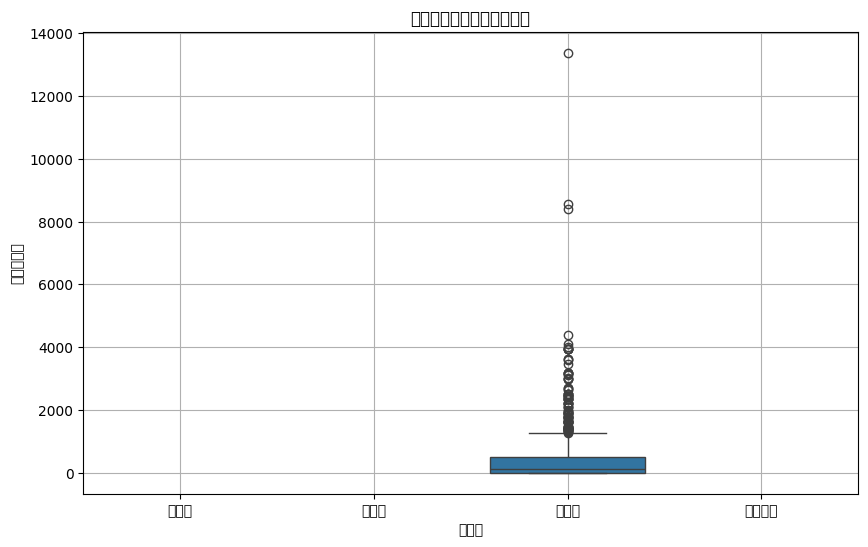

/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12507 (\N{KATAKANA LETTER HO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/

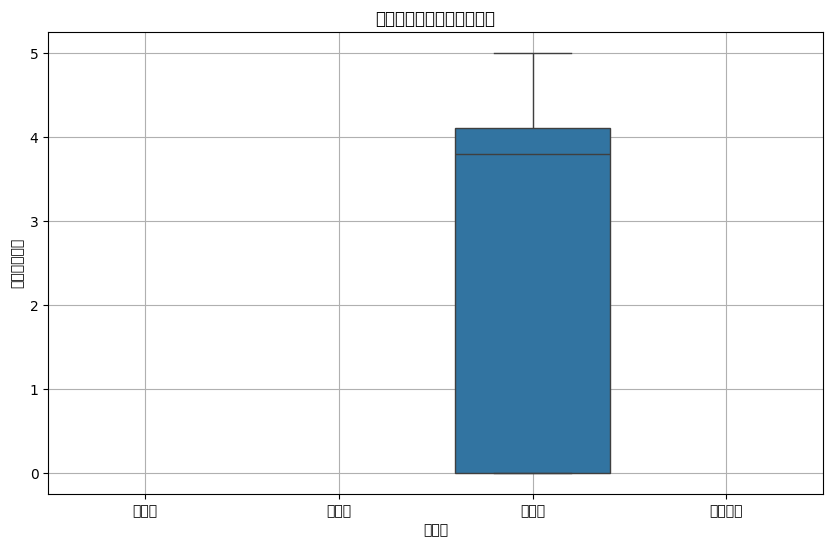

/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12499 (\N{KATAKANA LETTER BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12517 (\N{KATAKANA LETTER SMALL YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3

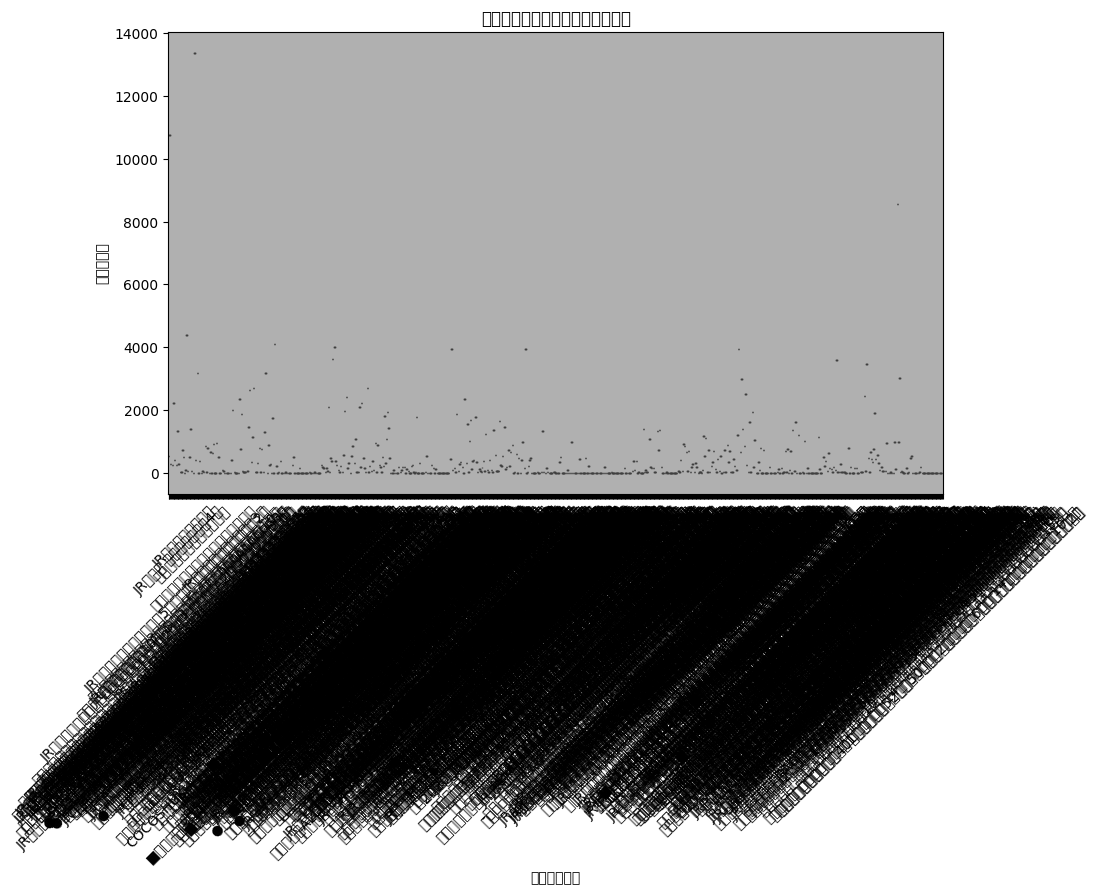

/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12507 (\N{KATAKANA LETTER HO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/

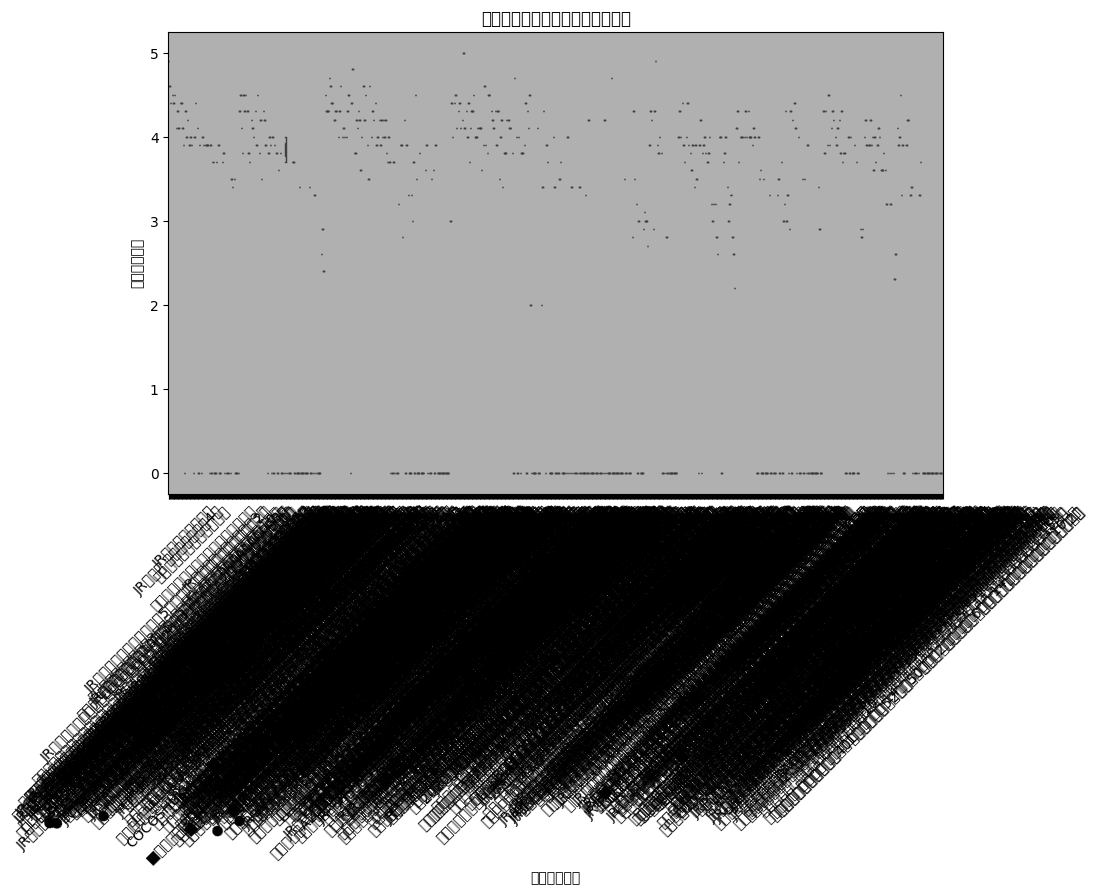

/var/folders/m0/xd8x8xps2j32jlry927rzzph0000gn/T/ipykernel_57079/2906411864.py:60: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='price_range', columns='ホテルの評価', values='レビュー数', aggfunc='mean')
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/yamamizusoto/.pyenv/versions/3.10.1/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canva

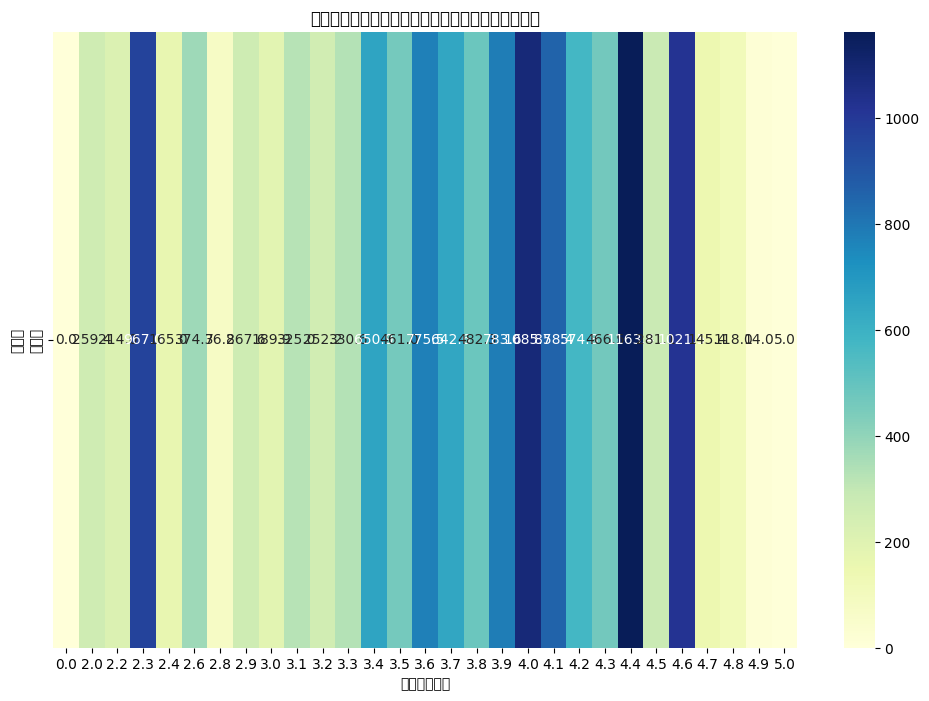

価格帯別のレビュー数分布:
             count        mean          std
price_range                                
低価格              0         NaN          NaN
中価格              0         NaN          NaN
高価格            759  492.320158  1003.015168
超高価格             0         NaN          NaN
アクセス情報別のレビュー数分布:
                                                    count   mean  std
アクセス情報                                                               
-擔斾扟慄擖扟墂 A4弌岥偐傜搆曕 5暘 /JR嶳庤慄 忋栰墂偐傜搆曕 16暘 /JR嶳庤慄 ...      1    0.0  NaN
.                                                       2  358.0  0.0
2020年9月NEW OPENホテル！日暮里駅から電車３分　赤土小学校前駅徒歩２分の好アクセス！        1   48.0  NaN
2023年8月1日より営業時間が24時間対応へ変更となりました                         1  461.0  NaN
2023擭8寧1擔傛傝塩嬈帪娫偑24帪娫懳墳傊曄峏偲側傝傑偟偨                         1  461.0  NaN
...                                                   ...    ...  ...
ＪＲ蒲田駅から直進徒歩１分、京浜急行線 京急蒲田駅から７分                           1    0.0  NaN
ＪＲ蒲田駅西口より徒歩約7分、東急池上線蓮沼駅より徒歩約3分                          1    0.0  NaN
ＪＲ蒲田駅

/var/folders/m0/xd8x8xps2j32jlry927rzzph0000gn/T/ipykernel_57079/2906411864.py:81: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  price_review_table = pd.pivot_table(df, values='レビュー数', index='price_range', aggfunc={'レビュー数': ['mean', 'count', 'std']})
/var/folders/m0/xd8x8xps2j32jlry927rzzph0000gn/T/ipykernel_57079/2906411864.py:83: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  price_rating_table = pd.pivot_table(df, values='ホテルの評価', index='price_range', aggfunc={'ホテルの評価': ['mean', 'count', 'std']})


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import japanize_matplotlib

# CSVファイルからデータを取得する関数

def fetch_data(csv_file='hotels.csv'):
    df = pd.read_csv(csv_file)
    # 不要な文字を削除して数値に変換
    df['一人あたり価格'] = df['一人あたり価格'].apply(lambda x: float(re.sub(r'[^\d]', '', str(x))) if pd.notnull(x) and re.sub(r'[^\d]', '', str(x)).strip() != '' else 0.0)
    df['価格情報'] = df['価格情報'].apply(lambda x: float(re.sub(r'[^\d]', '', str(x))) if pd.notnull(x) and re.sub(r'[^\d]', '', str(x)).strip() != '' else 0.0)
    df['ホテルの評価'] = df['ホテルの評価'].apply(lambda x: float(re.sub(r'[^\d.]', '', str(x))) if pd.notnull(x) and re.sub(r'[^\d.]', '', str(x)).strip() != '' else 0.0)
    df['レビュー数'] = df['レビュー数'].apply(lambda x: int(re.sub(r'[^\d]', '', str(x))) if pd.notnull(x) and re.sub(r'[^\d]', '', str(x)).strip() != '' else 0)
    return df

# 価格帯別のレビュー数分布をプロットする関数
def plot_price_vs_reviews(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='price_range', y='レビュー数', data=df)
    plt.title('価格帯とレビュー数の関係')
    plt.xlabel('価格帯')
    plt.ylabel('レビュー数')
    plt.grid(True)
    plt.show()

# 価格帯別のホテル評価の分布をプロットする関数
def plot_price_vs_rating(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='price_range', y='ホテルの評価', data=df)
    plt.title('価格帯とホテル評価の関係')
    plt.xlabel('価格帯')
    plt.ylabel('ホテルの評価')
    plt.grid(True)
    plt.show()

# アクセス情報別のレビュー数分布をプロットする関数
def plot_access_vs_reviews(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='アクセス情報', y='レビュー数', data=df)
    plt.title('アクセス情報とレビュー数の関係')
    plt.xlabel('アクセス情報')
    plt.ylabel('レビュー数')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# アクセス情報別のホテル評価分布をプロットする関数
def plot_access_vs_rating(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='アクセス情報', y='ホテルの評価', data=df)
    plt.title('アクセス情報とホテル評価の関係')
    plt.xlabel('アクセス情報')
    plt.ylabel('ホテルの評価')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# 価格帯別のホテル評価とレビュー数のヒートマップを作成する関数
def plot_price_review_heatmap(df):
    heatmap_data = df.pivot_table(index='price_range', columns='ホテルの評価', values='レビュー数', aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title('価格帯別のホテル評価とレビュー数のヒートマップ')
    plt.xlabel('ホテルの評価')
    plt.ylabel('価格帯')
    plt.show()

# 主な処理
csv_file = 'hotels.csv'
df = fetch_data(csv_file)
df['price_range'] = pd.cut(df['一人あたり価格'], bins=[0, 5000, 10000, 20000, 50000], labels=['低価格', '中価格', '高価格', '超高価格'])

# 図形の作成
plot_price_vs_reviews(df)
plot_price_vs_rating(df)
plot_access_vs_reviews(df)
plot_access_vs_rating(df)
plot_price_review_heatmap(df)

# ピボットテーブルの作成
price_review_table = pd.pivot_table(df, values='レビュー数', index='price_range', aggfunc={'レビュー数': ['mean', 'count', 'std']})
access_review_table = pd.pivot_table(df, values='レビュー数', index='アクセス情報', aggfunc={'レビュー数': ['mean', 'count', 'std']})
price_rating_table = pd.pivot_table(df, values='ホテルの評価', index='price_range', aggfunc={'ホテルの評価': ['mean', 'count', 'std']})
access_rating_table = pd.pivot_table(df, values='ホテルの評価', index='アクセス情報', aggfunc={'ホテルの評価': ['mean', 'count', 'std']})

print("価格帯別のレビュー数分布:")
print(price_review_table)

print("アクセス情報別のレビュー数分布:")
print(access_review_table)

print("価格帯別のホテル評価分布:")
print(price_rating_table)

print("アクセス情報別のホテル評価分布:")
print(access_rating_table)
